# Accidents en Nouvelle Calédonie

Basé publiées par le Ministère de l'Interieur publiée sur [data.gouv.nc](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2020/)

In [ ]:
!pip install scikit_learn folium seaborn forecast

In [51]:
import pandas as pd
import sklearn
import folium
import matplotlib.pyplot as plt
import seaborn as sns

## Récupération des données sources sur data.gouv.*fr*
Il n'y a pas de données avant 2019 pour la Nouvelle Calédonie

In [ ]:
%%bash
mkdir -p data/accidents
# caracteristiques-2020.csv
wget https://www.data.gouv.fr/fr/datasets/r/07a88205-83c1-4123-a993-cba5331e8ae0 -O data/accidents/caracteristiques-2020.csv
# 2019
wget https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a -O data/accidents/caracteristiques-2019.csv
# usagers-2020.csv
wget https://www.data.gouv.fr/fr/datasets/r/78c45763-d170-4d51-a881-e3147802d7ee -O data/accidents/usagers-2020.csv
# 2019
wget https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028 -O data/accidents/usagers-2019.csv

In [8]:
caracteristiques = pd.read_csv('data/accidents/caracteristiques-2020.csv', delimiter=';')
caracteristiques =  pd.concat([caracteristiques, pd.read_csv('data/accidents/caracteristiques-2019.csv', delimiter=';')])
print(caracteristiques.head())
caracteristiques.describe()

        Num_Acc  jour  mois    an   hrmn  lum dep    com  agg  int  atm  col  \
0  202000000001     7     3  2020  16:55    1  91  91657    2    3    1    3   
1  202000000002     7     3  2020  08:35    2  91  91657    2    9    7    6   
2  202000000003     7     3  2020  13:30    1  91  91174    2    2    1    3   
3  202000000004     7     3  2020  18:50    5  91  91215    2    1    1    6   
4  202000000005     7     3  2020  11:00    1  77  77181    1    6    1    2   

                       adr         lat       long  
0  HENRI BARBUSSE (AVENUE)  48,7053500  2,4384100  
1        MOUSSEAUX(CHEMIN)  48,6900000  2,4100000  
2           CARNOT(AVENUE)  48,6106700  2,4758200  
3     VICTOR HUGO (AVENUE)  48,6978200  2,5244600  
4  LAGNY  (RUE DE  ) - D35  48,8286457  2,7059707  


,Num_Acc,jour,mois,an,lum,agg,int,atm,col
count,1.065840e+05,106584.000000,106584.000000,106584.000000,106584.000000,106584.000000,106584.000000,106584.000000,106584.000000
mean,2.019448e+11,15.656778,6.710454,2019.447947,1.945827,1.645397,2.041244,1.619164,4.057982
std,4.972579e+07,8.722528,3.412225,0.497285,1.505150,0.478395,2.004140,1.680102,2.036893
min,2.019000e+11,1.000000,1.000000,2019.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000
25%,2.019000e+11,8.000000,4.000000,2019.000000,1.000000,1.000000,1.000000,1.000000,3.000000
50%,2.019001e+11,16.000000,7.000000,2019.000000,1.000000,2.000000,1.000000,1.000000,3.000000
75%,2.020000e+11,23.000000,10.000000,2020.000000,3.000000,2.000000,2.000000,1.000000,6.000000
max,2.020000e+11,31.000000,12.000000,2020.000000,5.000000,2.000000,9.000000,9.000000,7.000000


In [10]:
usagers = pd.read_csv('data/accidents/usagers-2020.csv', delimiter=';')
usagers = pd.concat([usagers, pd.read_csv('data/accidents/usagers-2019.csv', delimiter=';')])
usagers.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202000000001,154 742 274,B01,1,1,1,1,1983,5,1,0,-1,-1,-1,-1
1,202000000001,154 742 275,A01,1,1,3,1,1982,5,2,6,-1,-1,-1,-1
2,202000000002,154 742 273,A01,1,1,1,1,1997,1,8,0,-1,-1,-1,-1
3,202000000002,154 742 273,A01,10,3,4,1,1967,5,0,-1,-1,3,3,1
4,202000000003,154 742 271,B01,1,1,1,1,1985,0,1,0,-1,-1,-1,-1


In [37]:
df_all = pd.merge(caracteristiques, usagers, how='left', left_on=['Num_Acc'], right_on=['Num_Acc'])

## Colonnes à garder
### Caracteristiques : 
- Num_Acc : Numéro d'identifiant de l’accident. 
- jour mois: Jour de l'accident. Mois de l'accident.
- an: Année de l'accident.
- hrmn: Heure et minutes de l'accident.
- lum: Lumière : conditions d’éclairage dans lesquelles l'accident s'est produit :
    1 – Plein jour
    2 – Crépuscule ou aube
    3 – Nuit sans éclairage public
    4 – Nuit avec éclairage public non allumé
    5 – Nuit avec éclairage public allumé
- atm: Conditions atmosphériques :
    -1 – Non renseigné
    1 – Normale
    2 – Pluie légère
    3 – Pluie forte
    4 – Neige - grêle
    5 – Brouillard - fumée
    6 – Vent fort - tempête
    7 – Temps éblouissant
    8 – Temps couvert
    9 – Autre     
    
### Usagers:
- grav: Gravité de blessure de l'usager, les usagers accidentés sont classés en trois catégories de victimes plus les indemnes :
    1 – Indemne
    2 – Tué
    3 – Blessé hospitalisé
    4 – Blessé léger

In [56]:
df = df_all.loc[df_all.dep.isin(['988']), ['jour' , 'mois', 'an' , 'grav', 'hrmn', 'lat', 'long', 'lum', 'atm']]

df['lum'] = df['lum'].astype("category")
df['atm'] = df['atm'].astype("category")
df['jour'] = df['jour'].astype("category")
df['mois'] = df['mois'].astype("category")
df['an'] = df['an'].astype("category")
df['grav'] = df['grav'].astype("category")

df = df.applymap(lambda x: x.strip().replace(',', '.') if isinstance(x, str) else x)
df["lat"] = pd.to_numeric(df["lat"], downcast="float")
df["long"] = pd.to_numeric(df["long"], downcast="float")

df.head()

,jour,mois,an,grav,hrmn,lat,long,lum,atm
174,8,3,2020,3,11:10,-20.934578,165.329254,1,1
175,8,3,2020,3,11:10,-20.934578,165.329254,1,1
176,8,3,2020,2,11:10,-20.934578,165.329254,1,1
177,8,3,2020,2,11:10,-20.934578,165.329254,1,1
178,8,3,2020,3,11:10,-20.934578,165.329254,1,1


In [43]:
df.describe()

,jour,mois,an,grav,hrmn,lat,long,lum,atm
count,1801,1801,1801,1801,1801,1801,1801,1801,1801
unique,31,12,2,4,291,676,674,5,6
top,9,10,2019,1,17:30,"-22,2306430","166,4423300",1,1
freq,89,221,903,709,28,13,13,1021,1510


## Répartition des accidents en NC par mois

<AxesSubplot:xlabel='mois'>

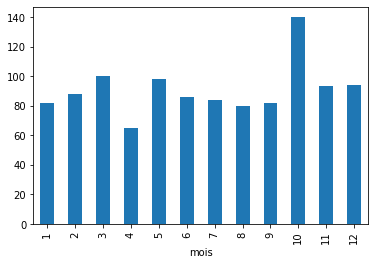

In [110]:
# on ne garde que les accidents de la NC
df1 = df
# et ceux où il y a des blessés
df1 = df1.loc[df.grav.isin([2,3,4]) ]
df1.groupby(['mois']).size().plot(kind="bar")

## Répartition des accidents en NC par jour du mois

<AxesSubplot:xlabel='jour'>

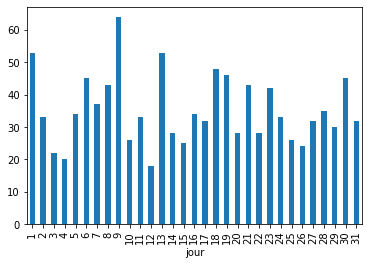

In [13]:
df1.groupby(['jour']).size().plot(kind="bar")

## Répartition par gravité
Gravité de blessure de l'usager, les usagers accidentés sont classés en trois catégories de victimes plus les indemnes :

1 – Indemne

2 – Tué

3 – Blessé hospitalisé

4 – Blessé léger

<AxesSubplot:xlabel='grav'>

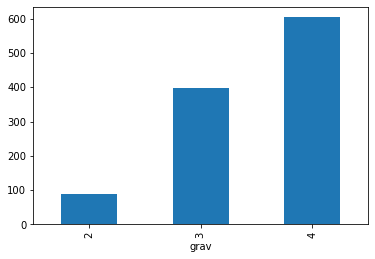

In [14]:
df1.groupby(['grav']).size().plot(kind="bar")

## Répartition par heure de la journée

<AxesSubplot:xlabel='hour'>

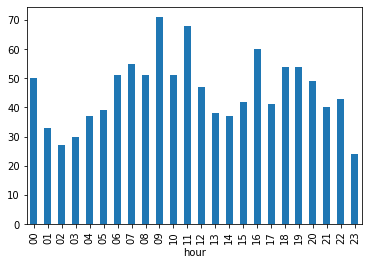

In [15]:
df1[['hour', 'min']] = df1['hrmn'].str.split(':', expand=True)
df1.groupby(['hour']).size().plot(kind="bar")

## Répartition sur l'année

<AxesSubplot:xlabel='day_of_year'>

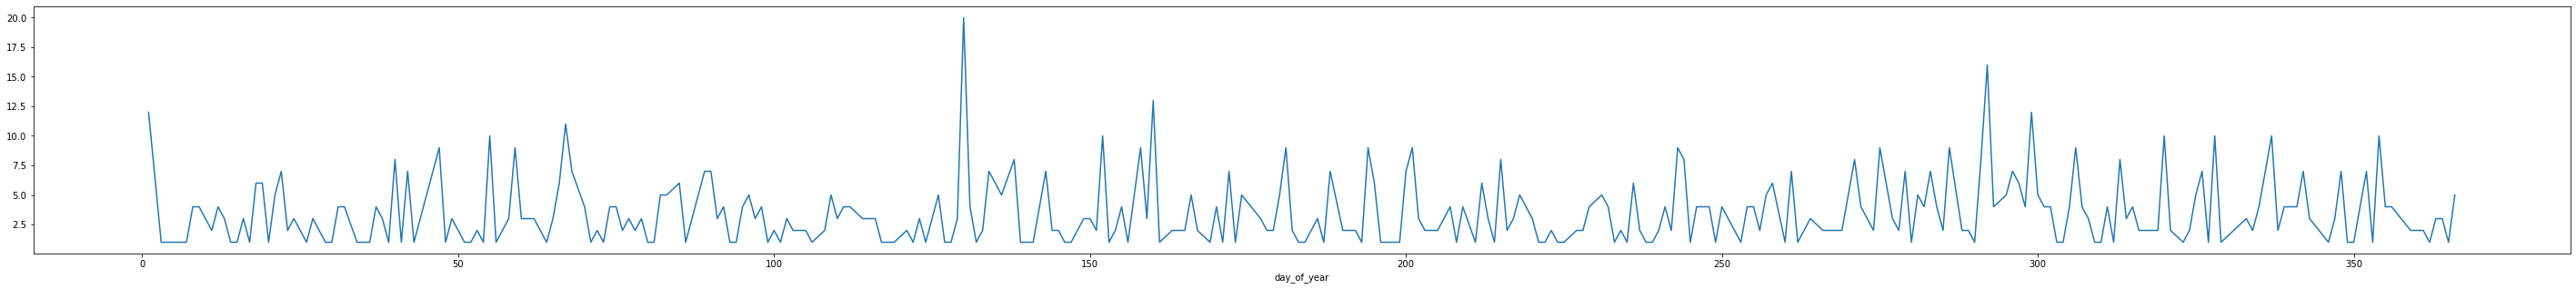

In [17]:
df1['day_of_year'] = pd.to_datetime(df1['jour'].astype(str) + "/" + df1['mois'].astype(str) + "/" + df1['an'].astype(str), format='%d/%m/%Y').dt.day_of_year
df1.groupby(['day_of_year']).size().plot(figsize=(50,5))

In [18]:
## Répartition sur le territoire 

In [ ]:
accident_loc = df1[['lat', 'long', 'grav']]

map = folium.Map(location=[accident_loc.lat.mean(), accident_loc.long.mean()], zoom_start=8, control_scale=True)
for index, location_info in accident_loc.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]], popup=location_info["grav"]).add_to(map)
map

In [57]:
df.dtypes

jour      int64
mois      int64
an        int64
grav      int64
hrmn     object
lat     float32
long    float32
lum       int64
atm       int64
dtype: object

## Recherche de corrélations

In [65]:
df2 = df[['jour', 'mois', 'an', 'grav', 'lat', 'long', 'lum', 'atm']]
grave1 = df2[df2['grav'] == 1]
grave2 = df2[df2['grav'] == 2]
grave3 = df2[df2['grav'] == 3]
grave4 = df2[df2['grav'] == 4]

<Figure size 432x288 with 0 Axes>

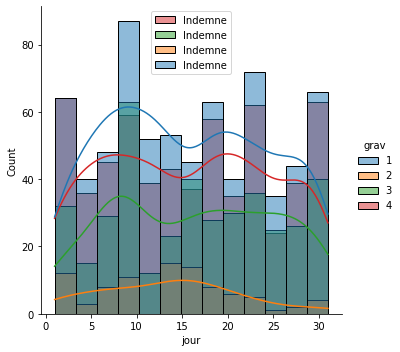

<Figure size 432x288 with 0 Axes>

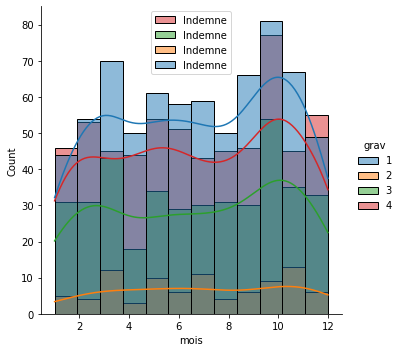

<Figure size 432x288 with 0 Axes>

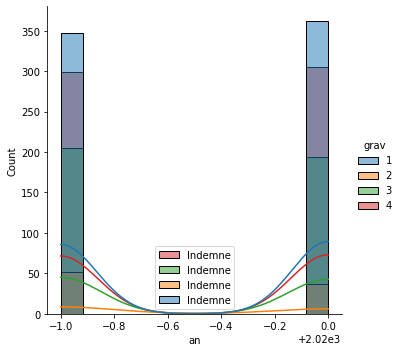

<Figure size 432x288 with 0 Axes>

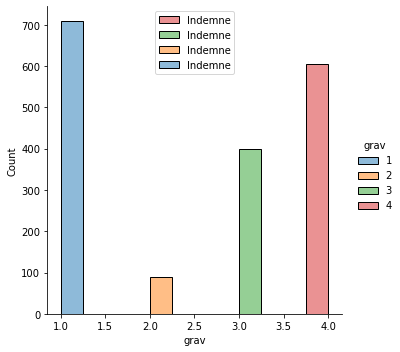

<Figure size 432x288 with 0 Axes>

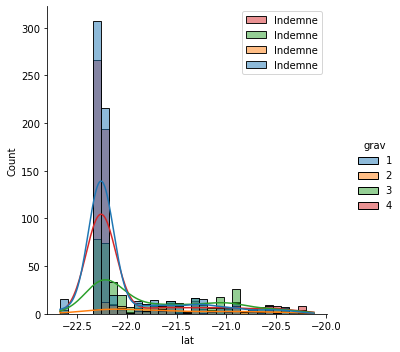

<Figure size 432x288 with 0 Axes>

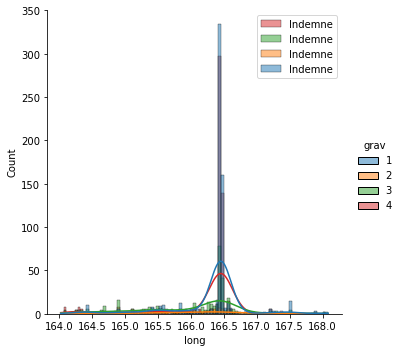

<Figure size 432x288 with 0 Axes>

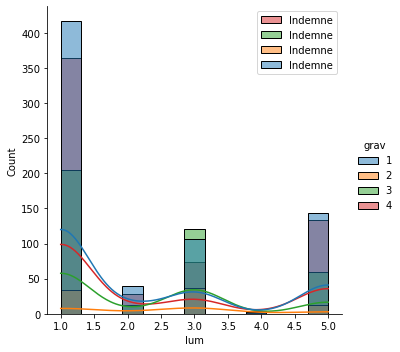

<Figure size 432x288 with 0 Axes>

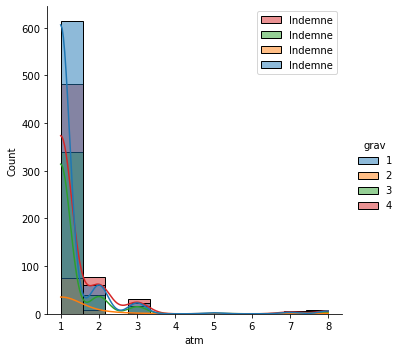

In [87]:

for col in df2:
    plt.figure()
    sns.color_palette("tab10")
    sns.displot(df2, x=col, hue="grav", label="Indemne", kde=True, palette="tab10")
    # sns.displot(grave2, x=col, label="Tué", kde=True, hue='grav')
    # sns.displot(grave3, x=col, label="Blessé hospitalisé", kde=True, hue='grav')
    # sns.displot(grave4, x=col, label="Blessé léger", kde=True, hue='grav')
    plt.legend()

## Essai de machine learning


In [116]:
df1['date'] = pd.to_datetime(df['jour'].astype(str) + "/" + df['mois'].astype(str) + "/" + df['an'].astype(str), format='%d/%m/%Y')
idx = pd.date_range(min(df1.date), max(df1.date))
data = df1.groupby(['date']).size().reset_index(name="y")
data = data.set_index(["date"], drop=True)
data.index = pd.DatetimeIndex(data.index)
data = data.reindex(idx, fill_value=0)
data.head()

/tmp/ipykernel_111/2047852478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.to_datetime(df['jour'].astype(str) + "/" + df['mois'].astype(str) + "/" + df['an'].astype(str), format='%d/%m/%Y')


,y
2019-01-01,6
2019-01-02,0
2019-01-03,0
2019-01-04,0
2019-01-05,0


Train dates : 2019-01-01 00:00:00 --- 2020-11-25 00:00:00  (n=695)
Test dates  : 2020-11-26 00:00:00 --- 2020-12-31 00:00:00  (n=36)


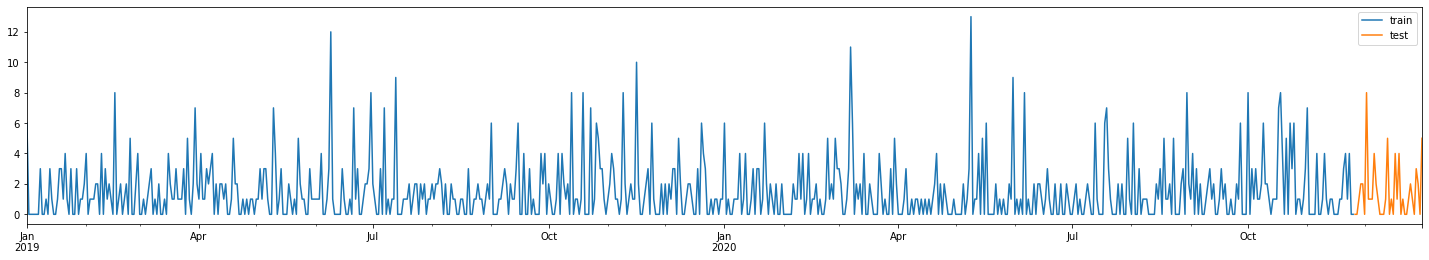

In [119]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(25, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [120]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

ModuleNotFoundError: No module named 'skforecast'

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['y'])
forecaster